In [1]:
!pip install pyarrow scikeras tensorflow keras pandas matplotlib

In [2]:
import pandas as pd

# Carregar o arquivo feather
df = pd.read_feather('Dados_Jan1980_mar2020_interpolado.feather')  

# Converter longitudes de 0–360 para -180–180
df['lon'] = df['lon'].apply(lambda x: x - 360 if x > 180 else x)

# Verificar valores mínimos e máximos para entender se conversão está ok
print(f"Longitude min: {df['lon'].min()}, max: {df['lon'].max()}")
print(f"Latitude min: {df['lat'].min()}, max: {df['lat'].max()}")

# Aplicar filtro para domínio Nordeste (lon e lat)
df_nordeste = df[
    (df['lon'] >= -46.5) & (df['lon'] <= -33.5) &
    (df['lat'] >= -19.1) & (df['lat'] <= -1.0)
]

print(f"Dados filtrados para Nordeste: {df_nordeste.shape[0]} linhas restantes")

# Analisar coluna t2m
target_col = "t2m"

if target_col not in df_nordeste.columns:
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada. Colunas disponíveis: {df_nordeste.columns.tolist()} ")

print("Valores ausentes por coluna (top):")
print(df_nordeste.isna().sum().sort_values(ascending=False).head(10))
display(df_nordeste[[target_col]].describe().T)

Longitude min: -88.75, max: -31.25
Latitude min: -58.75, max: 8.75
Dados filtrados para Nordeste: 23184 linhas restantes
Valores ausentes por coluna (top):
year       0
month      0
lat        0
lon        0
temp850    0
press      0
shum850    0
t2m        0
u500       0
u850       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
t2m,23184.0,24.652708,1.94606,16.6644,23.358475,24.94945,26.155625,30.0916


In [3]:
# t2m como target
# temperatura do ar medida a 2 metros de altura (padrão meteorológico para representar a temperatura próxima à superfície)

target_col = "t2m"

if target_col not in df_nordeste.columns:
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada. Colunas disponíveis: {df_nordeste.columns.tolist()} ")

print("Valores ausentes por coluna (top):")
print(df_nordeste.isna().sum().sort_values(ascending=False).head(10))
display(df_nordeste[[target_col]].describe().T)

Valores ausentes por coluna (top):
year       0
month      0
lat        0
lon        0
temp850    0
press      0
shum850    0
t2m        0
u500       0
u850       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
t2m,23184.0,24.652708,1.94606,16.6644,23.358475,24.94945,26.155625,30.0916



Correlação (valor absoluto) do alvo com outras variáveis:


t2m        1.000000
lat        0.638502
u500      -0.607117
press      0.604432
u850      -0.404422
temp850    0.349165
lon        0.273792
v850       0.225592
year       0.108441
shum850    0.076122
month      0.021540
prgpcp     0.003987
Name: t2m, dtype: float64

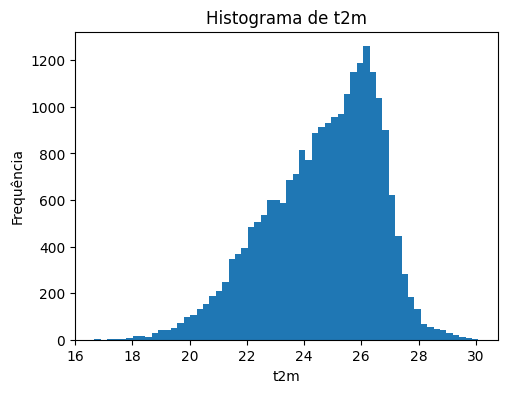

In [4]:
# 3.1 Distribuição da variável alvo (histograma + boxplot)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df_nordeste[target_col].dropna(), bins=60)
plt.title(f"Histograma de {target_col}")
plt.xlabel(target_col)
plt.ylabel("Frequência")




# 3.2 Matriz de correlação (apenas numéricas) entre target e demais atributos

num_cols = df_nordeste.select_dtypes(include="number").columns.tolist()
if target_col not in num_cols:
    print("Alvo não é numérico — verifique.")
else:
    corr = df_nordeste[num_cols].corr()[target_col].sort_values(key=lambda x: x.abs(), ascending=False)
    print("\nCorrelação (valor absoluto) do alvo com outras variáveis:")
    display(corr.head(12))

In [5]:
k = 8
corr_vals = df_nordeste[num_cols].corr()[target_col].abs().sort_values(ascending=False)
candidate_features = [c for c in corr_vals.index if c != target_col][:k]
print("Features candidatas selecionadas automaticamente:", candidate_features)

# Criar X e y, e remover linhas com NA nas colunas escolhidas
X = df_nordeste[candidate_features].copy()
y = df_nordeste[target_col].copy()
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)
print("Shape after drop NA:", X.shape, y.shape)

Features candidatas selecionadas automaticamente: ['lat', 'u500', 'press', 'u850', 'temp850', 'lon', 'v850', 'year']
Shape after drop NA: (23184, 8) (23184,)


In [6]:
# Ajuste o nome da coluna de tempo

time_col_candidates = [c for c in df_nordeste.columns if "date" in c.lower() or "data" in c.lower() or "time" in c.lower()]
print("Possíveis colunas de tempo:", time_col_candidates)

# Se existir uma coluna temporal, reconstituir X e y ordenados; se não, assumimos que os dados já estão em ordem temporal.
time_col = time_col_candidates[0] if time_col_candidates else None
if time_col:
    df_tmp = df_nordeste.loc[mask].sort_values(time_col).reset_index(drop=True)
    X = df_tmp[candidate_features]
    y = df_tmp[target_col]
    print("ordenado por", time_col)
else:
    print("Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.")

Possíveis colunas de tempo: []
Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.


In [7]:
# normalização dos dados
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

In [8]:
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=32, activation="tanh", dropout_rate = 0.0, learning_rate=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_scaled.shape[1],)))
    for i in range (n_neurons):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate and dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="linear"))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# Wrapper scikeras
keras_reg = KerasRegressor(model=build_model, verbose=0)

2025-08-11 17:03:54.329136: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 17:03:55.248601: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 17:03:55.706358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754942636.118592    5338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754942636.226721    5338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754942637.152484    5338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# define os hiperparâmetros e o GridSearchCV com TimeSeriesSplit interno para evitar vazamento
tscv_inner = TimeSeriesSplit(n_splits=3)

param_grid = {
    "model__n_hidden": [1,2],
    "model__n_neurons": [16,32],
    "model__activation": ["tanh", "relu"],
    "model__learning_rate": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "model__dropout_rate": [0.0, 0.2],
    "epochs": [10],
}

grid = GridSearchCV (
    estimator=keras_reg,
    param_grid=param_grid,
    cv=tscv_inner,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    verbose=2    
)

print("Grid definido com", len(param_grid), "parâmetros a explorar (produto cartesiano).")

Grid definido com 7 parâmetros a explorar (produto cartesiano).


In [10]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

tscv_outer = TimeSeriesSplit(n_splits=3)

# nested CV manual: para cada fold externo, rodar o GridSearch no treino e avaliar no teste.

outer_scores = []
fold_idx = 0

for train_idx, test_idx in tscv_outer.split(X_scaled):
    fold_idx +=1
    print(f"\n--- Fold externo {fold_idx} ---")
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Ajustar o grid no X_train (com validação temporal interna definida no grid)
    grid.fit(X_train, y_train)
    best = grid.best_params_
    print("Melhores parâmetros (grid interno):", best)
    print("Best CV score (neg MSE):", grid.best_score_)

    # Avaliar melhor modelo encontrado no conjunto de teste externo
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    mse_fold = np.mean((y_test - y_pred)**2)
    mae_fold = np.mean(np.abs(y_test - y_pred))
    print(f"Fold {fold_idx} — MSE: {mse_fold:.4f}, MAE: {mae_fold:.4f}")
    outer_scores.append({"fold": fold_idx, "mse": mse_fold, "mae": mae_fold})

# resumo dos folds externos
import pandas as pd
results_outer = pd.DataFrame(outer_scores)
print("\nResumo nested CV:")
display(results_outer)
print("MSE médio:", results_outer["mse"].mean(), "MAE médio:", results_outer["mae"].mean())


--- Fold externo 1 ---
Fitting 3 folds for each of 64 candidates, totalling 192 fits


E0000 00:00:1754942657.538365    5338 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754942657.549652    5338 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=   4.8s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=   4.4s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=   5.3s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=32; total time=   6.9s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=32; total time=   7.4s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neuro

,fold,mse,mae
0,1,0.980208,0.828651
1,2,0.386987,0.487689
2,3,0.620136,0.628291


MSE médio: 0.6624438713594842 MAE médio: 0.6482104162893214


In [11]:
# Treinar o modelo final usando todos os dados com os melhores parâmetros encontrados do último grid
best_params = grid.best_params_
print("Melhores parâmetros finais (último grid executado):", best_params)

model_kwargs = {
    "n_hidden": best_params.get("model__n_hidden", 1),
    "n_neurons": best_params.get("model__n_neurons", 32),
    "activation": best_params.get("model__activation", "tanh"),
    "dropout_rate": best_params.get("model__dropout_rate", 0.0),
    "learning_rate": best_params.get("model__learning_rate", 1e-3),
}

final_model = build_model(**model_kwargs)

# Treino final
final_model.fit(X_scaled, y, epochs=best_params.get("epochs", 30), batch_size=best_params.get("batch_size",32), verbose=1)

#  Previsões com o modelo final (no próprio conjunto, apenas para inspeção)
y_pred_all = final_model.predict(X_scaled).ravel()


# Métricas finais
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_final = mean_squared_error(y, y_pred_all)
mae_final = mean_absolute_error(y, y_pred_all)
print(f"MSE final (treino completo): {mse_final:.4f}")
print(f"MAE final (treino completo): {mae_final:.4f}")

Melhores parâmetros finais (último grid executado): {'batch_size': 32, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.0, 'model__learning_rate': 0.001, 'model__n_hidden': 2, 'model__n_neurons': 32}
Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 21.4318 - mae: 1.7152
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3959 - mae: 0.4909
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3596 - mae: 0.4670
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3614 - mae: 0.4688
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3439 - mae: 0.4572
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3973 - mae: 0.4941
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3086 - mae: 0.4282
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3056 - mae: 0.4268
Epoch 9/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3316 - mae: 0.4461
Epoch 10/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

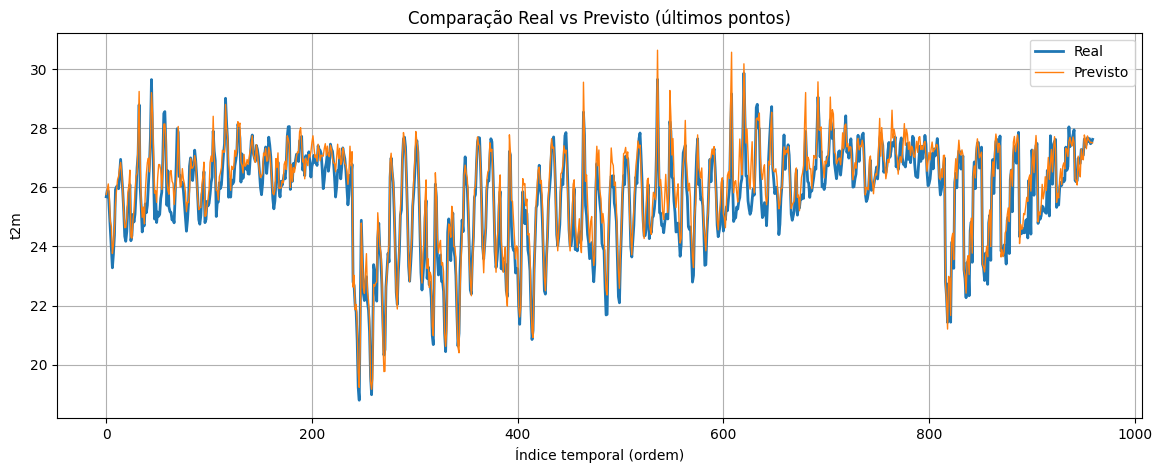

In [21]:
# Vamos mostrar um trecho temporal (por exemplo últimos N pontos) para comparar real x previsto
N = 960
plt.figure(figsize=(14,5))
plt.plot(y.values[-N:], label="Real", linewidth=2)
plt.plot(y_pred_all[-N:], label="Previsto", linewidth=1)
plt.title("Comparação Real vs Previsto (últimos pontos)")
plt.xlabel("Índice temporal (ordem)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()